<a href="https://colab.research.google.com/github/seolibek/Tufts2024/blob/main/tSNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TSNE on HSI data - SalinasA

Use as a reference when running with other datasets to generate accuracy plots (cleaned up code, significantly)

In [1]:
from umap_script import loadHSI, show_clusterable_embedding, visualize_tsne, compare_umap, tsne_projection_2d, animation
from sklearn.manifold import TSNE

import numpy as np
import random
import matplotlib.pyplot as plt
import umap

/Users/aryamantepal/anaconda3/envs/ML-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading in the HSI Data

In [2]:
salinasA_path = 'data/SalinasA_corrected.mat'
salinasA_gt_path = 'data/SalinasA_gt.mat'

X, M, N, D, HSI, GT, Y, n, K = loadHSI(salinasA_path, salinasA_gt_path, 'salinasA_corrected', 'salinasA_gt')

In [3]:
print(HSI.shape)
print(GT.shape)

(7138, 204)
(83, 86)


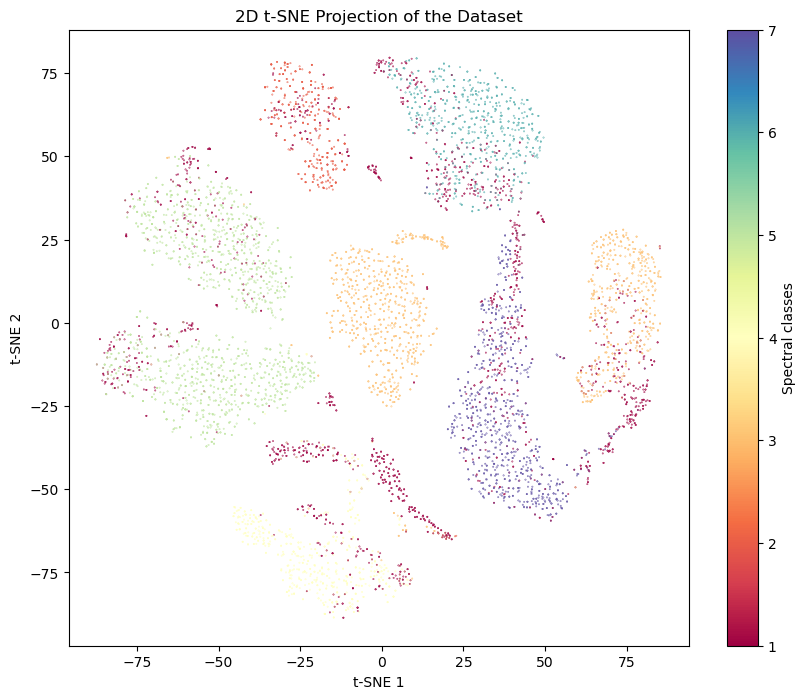

In [4]:
tsne = tsne_projection_2d(HSI, GT)

/Users/aryamantepal/anaconda3/envs/ML-env/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


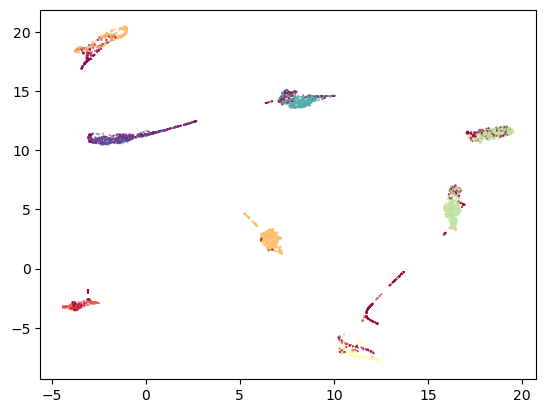

In [5]:
clust_emb = show_clusterable_embedding(HSI, GT)

In [6]:
!pip install ffmpeg

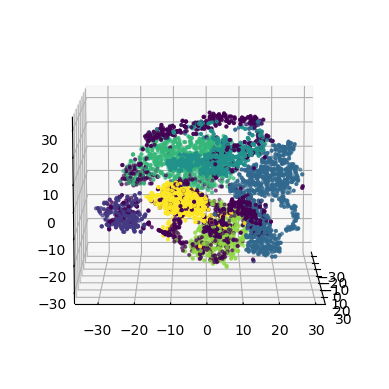

In [7]:
animation(HSI,GT)

/Users/aryamantepal/anaconda3/envs/ML-env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/aryamantepal/anaconda3/envs/ML-env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.1911025141903161
[0 0 0 ... 3 3 3]
0.3790962416831678
[3 3 3 ... 5 5 5]


/Users/aryamantepal/anaconda3/envs/ML-env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/aryamantepal/anaconda3/envs/ML-env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.2370190884062119
[1 1 1 ... 0 0 0]
0.3790962416831678
[3 3 3 ... 5 5 5]


/Users/aryamantepal/anaconda3/envs/ML-env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/aryamantepal/anaconda3/envs/ML-env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.26900601309037575
[4 4 4 ... 2 2 2]
0.3790962416831678
[3 3 3 ... 5 5 5]


/Users/aryamantepal/anaconda3/envs/ML-env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/aryamantepal/anaconda3/envs/ML-env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.2343581550938001
[0 0 0 ... 6 6 6]
0.3790962416831678
[3 3 3 ... 5 5 5]


/Users/aryamantepal/anaconda3/envs/ML-env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/aryamantepal/anaconda3/envs/ML-env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.247423273957535
[0 0 4 ... 5 5 5]
0.3790962416831678
[3 3 3 ... 5 5 5]


/Users/aryamantepal/anaconda3/envs/ML-env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/aryamantepal/anaconda3/envs/ML-env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.3029016159478585
[2 2 2 ... 5 5 5]
0.3790962416831678
[3 3 3 ... 5 5 5]


/Users/aryamantepal/anaconda3/envs/ML-env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/aryamantepal/anaconda3/envs/ML-env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.3513895247493322
[1 1 1 ... 0 0 0]
0.3790962416831678
[3 3 3 ... 5 5 5]


/Users/aryamantepal/anaconda3/envs/ML-env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/aryamantepal/anaconda3/envs/ML-env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.4798947078399623
[0 0 0 ... 3 3 3]
0.3790962416831678
[3 3 3 ... 5 5 5]


/Users/aryamantepal/anaconda3/envs/ML-env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/aryamantepal/anaconda3/envs/ML-env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.5090236780953622
[0 0 0 ... 3 3 3]
0.3790962416831678
[3 3 3 ... 5 5 5]


/Users/aryamantepal/anaconda3/envs/ML-env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/aryamantepal/anaconda3/envs/ML-env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.5110457493805589
[6 6 6 ... 5 5 5]
0.3790962416831678
[3 3 3 ... 5 5 5]


/Users/aryamantepal/anaconda3/envs/ML-env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/aryamantepal/anaconda3/envs/ML-env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.49443309078455094
[0 0 0 ... 1 1 1]
0.3790962416831678
[3 3 3 ... 5 5 5]


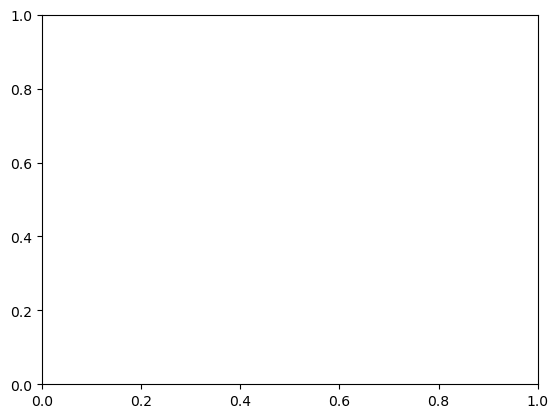

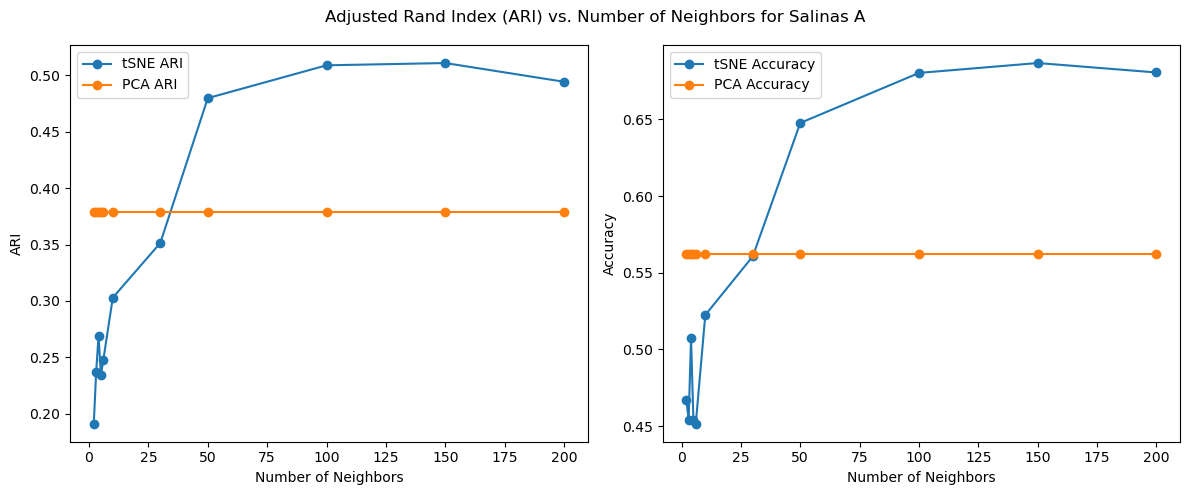

In [6]:
compare_umap(HSI, GT, 'Salinas A', compare_dim=False, compare_neighbors=True, tSNE=True)